# 📊 Credit Risk – Final Model Visualization

This notebook focuses **exclusively on model visualization**.

It loads the **trained preprocessing pipeline** and the **final stacking model**, evaluates them on a test split, and produces:

- Key metrics (AUC, F1, optimal threshold)
- ROC Curve
- Precision–Recall Curve
- Score distribution plots
- KS Curve (Kolmogorov–Smirnov)
- Permutation-based feature importance
- (Optional) Score distribution for the official scoring dataset

⚠️ **No training occurs here.**  
Training is done through the reproducible pipelines in `src/pipelines/`.


🧩 Imports & Paths

In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
)
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

plt.style.use("default")

ROOT = Path.cwd().resolve().parent

RAW_DATA_PATH = ROOT/"data"/"interim"/"train_clean_headers.parquet"
PREPROCESSOR_PATH = ROOT/"model_service"/"artifacts"/"preprocessing_pipeline.joblib"
MODEL_PATH = ROOT/"model_service"/"artifacts"/"model_stack_prod.pkl"
METADATA_PATH = ROOT/"model_service"/"artifacts"/"model_metadata.json"

TARGET_COL = "TARGET_LABEL_BAD=1"


In [3]:
import sys
from pathlib import Path

# Add project root to Python path
ROOT = Path.cwd().resolve().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

SRC = ROOT / "src"
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

print("🔧 PYTHONPATH updated:")
for p in sys.path[:5]:
    print("   →", p)


🔧 PYTHONPATH updated:
   → C:\AnyoneIA\credit-risk\src
   → C:\AnyoneIA\credit-risk
   → C:\Users\ext83752\AppData\Local\Programs\Python\Python310\python310.zip
   → C:\Users\ext83752\AppData\Local\Programs\Python\Python310\DLLs
   → C:\Users\ext83752\AppData\Local\Programs\Python\Python310\lib


🧩 Load Data & Artifacts

In [4]:
print("📥 Loading interim dataset...")
df = pd.read_parquet(RAW_DATA_PATH)
print(f"Shape: {df.shape}")

if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found.")

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

print(f"🎯 Positive rate (target=1): {y.mean():.4f}")

print("\n📥 Loading preprocessing pipeline...")
preprocessor = joblib.load(PREPROCESSOR_PATH)

print("📥 Loading final model...")
model = joblib.load(MODEL_PATH)

print("📥 Loading metadata...")
with open(METADATA_PATH, "r") as f:
    metadata = json.load(f)

metadata


📥 Loading interim dataset...
Shape: (50000, 54)
🎯 Positive rate (target=1): 0.2608

📥 Loading preprocessing pipeline...
📥 Loading final model...
📥 Loading metadata...


{'auc': 0.6476177456394576,
 'best_threshold': 0.24663666387399039,
 'best_f1': 0.4549808428689266,
 'calibrated': True}

🧩 Train/Test Split + Transform + Predict

In [5]:
print("🔀 Performing stratified 80/20 split...")

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"X_train_raw: {X_train_raw.shape}")
print(f"X_test_raw:  {X_test_raw.shape}")

print("\n🔄 Applying preprocessing to test set...")
X_test = preprocessor.transform(X_test_raw)
print(f"X_test transformed: {X_test.shape}")

print("\n🤖 Predicting probabilities with final model...")
y_proba = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_proba)
print(f"🏁 AUC (recomputed on test) = {auc:.4f}")


🔀 Performing stratified 80/20 split...
X_train_raw: (40000, 53)
X_test_raw:  (10000, 53)

🔄 Applying preprocessing to test set...
X_test transformed: (10000, 151)

🤖 Predicting probabilities with final model...


c:\AnyoneIA\credit-risk\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\AnyoneIA\credit-risk\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\AnyoneIA\credit-risk\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


🏁 AUC (recomputed on test) = 0.6476


🧩 Key Metrics & Threshold

In [6]:
best_threshold = metadata.get("best_threshold", 0.5)
best_f1 = metadata.get("best_f1", None)

print(f"🔎 Optimal threshold (metadata): {best_threshold:.4f}")
if best_f1 is not None:
    print(f"🎯 Best F1 (metadata): {best_f1:.4f}")

y_pred = (y_proba >= best_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\n📊 Confusion matrix (metadata threshold):")
print(cm)
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

print("\n📄 Classification report:")
print(classification_report(y_test, y_pred, digits=4))


🔎 Optimal threshold (metadata): 0.2466
🎯 Best F1 (metadata): 0.4550

📊 Confusion matrix (metadata threshold):
[[3548 3844]
 [ 708 1900]]
TN=3548, FP=3844, FN=708, TP=1900

📄 Classification report:
              precision    recall  f1-score   support

           0     0.8336    0.4800    0.6092      7392
           1     0.3308    0.7285    0.4550      2608

    accuracy                         0.5448     10000
   macro avg     0.5822    0.6043    0.5321     10000
weighted avg     0.7025    0.5448    0.5690     10000



🧩 ROC & Precision–Recall Curves

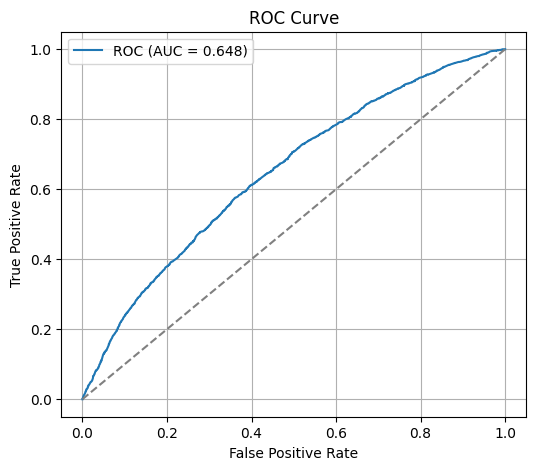

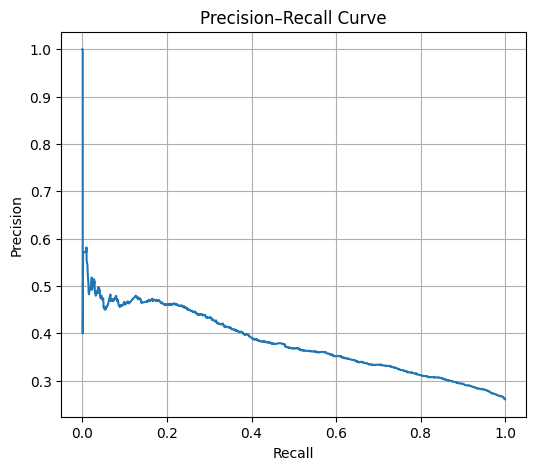

In [7]:
# ROC
fpr, tpr, roc_thr = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Precision–Recall
prec, rec, pr_thr = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(rec, prec, label="Precision–Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.show()


🧩 Score Distributions

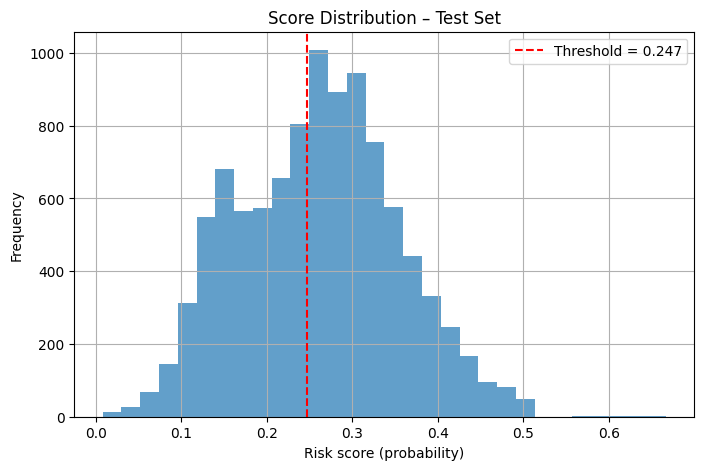

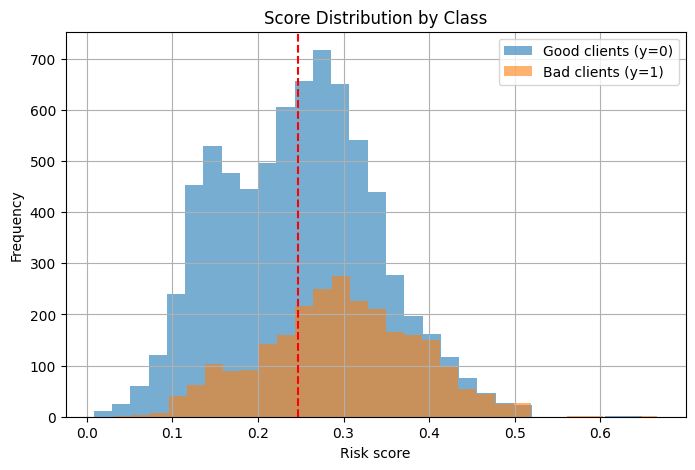

In [8]:
plt.figure(figsize=(8, 5))
plt.hist(y_proba, bins=30, alpha=0.7)
plt.axvline(best_threshold, color="red", linestyle="--", label=f"Threshold = {best_threshold:.3f}")
plt.xlabel("Risk score (probability)")
plt.ylabel("Frequency")
plt.title("Score Distribution – Test Set")
plt.legend()
plt.grid(True)
plt.show()

# By class
plt.figure(figsize=(8, 5))
plt.hist(y_proba[y_test == 0], bins=30, alpha=0.6, label="Good clients (y=0)")
plt.hist(y_proba[y_test == 1], bins=30, alpha=0.6, label="Bad clients (y=1)")
plt.axvline(best_threshold, color="red", linestyle="--")
plt.xlabel("Risk score")
plt.ylabel("Frequency")
plt.title("Score Distribution by Class")
plt.legend()
plt.grid(True)
plt.show()


🧩 KS Curve (Credit Risk Classic)

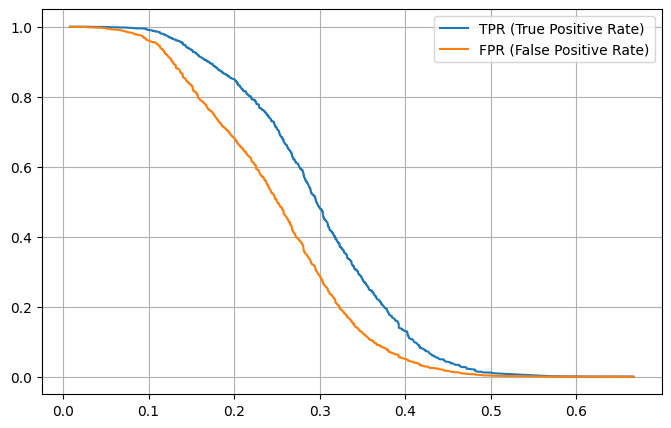

In [11]:
min_len = min(len(roc_thr), len(tpr), len(fpr))

thr_plot = roc_thr[:min_len]
tpr_plot = tpr[:min_len]
fpr_plot = fpr[:min_len]

plt.figure(figsize=(8,5))
plt.plot(thr_plot, tpr_plot, label="TPR (True Positive Rate)")
plt.plot(thr_plot, fpr_plot, label="FPR (False Positive Rate)")
plt.legend()
plt.grid(True)
plt.show()
